In [1]:
from blackbox37 import check
import string
import random
from matplotlib import pyplot as plt
%matplotlib inline

from cross_overs import CrossOverRandomTwo
from explorations import RandomExploration, SimpleExploration
from mutations import NCharMutation
from population import Population, Individual

In [2]:
available_characters = list(string.ascii_uppercase) + [str(i) for i in range(10)]
available_characters.append("")
GROUP_ID = 2

In [3]:
print(available_characters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '']


In [4]:
def generate():
#     size = random.randint(12, 18)
    size = 18
    individual = random.choices(available_characters, k=size)
    while len(individual) < 12:
        individual = random.choices(available_characters, k=size)
    return individual

In [5]:
sol = ''.join(generate())
print(sol)
print(check(group_number=2, attempt=sol))

0X4V8Q9L1WICD0KGR
0.42594537815126055


In [26]:
def plot_results(average, bests, details):
    plt.figure(figsize=(20, 7))
    plt.plot(average, color='green', linestyle='dotted', label='Moyenne de la population actuelle')
    plt.plot(bests, color='red', label='Maximum trouvé')
    plt.xlabel('Itérations')
    plt.ylabel('Scores')
    plt.legend(loc="lower right")
    if details:
        if details['title']:
            plt.suptitle(details['title'], y=0.97, fontsize=18)
        if details['subtitle']:
            plt.title(details['subtitle'])
    plt.show()

# Evolution des populations

In [7]:
def evolve_population(population, max_epochs=1000, show_progress=False, progress_step=10):
    averages = []
    bests = []
    best = population.population[0]
    for epoch in range(max_epochs):
        population.evaluate()
        b = population.get_max()
        best = b if b.score > best.score else best
        bests.append(best.score)
        average = population.get_average_score()
        averages.append(average)
        
        if show_progress:
            print(f"Epoch {epoch+1}/{max_epochs}: Best {best.phenotype()} ({best.score}) (average: {average})")
            
        if best.score == 1.0:
            print(f"Best found: {best.phenotype()} at Epoch {epoch+1}/{max_epochs}!")
            break
            
        population.evolve()
    return averages, bests, best

## Recherche de la solution

In [36]:
def search(population_size=100, epochs=100):
    cross_over = CrossOverRandomTwo(0.9)
    mutation = NCharMutation(n=1)
    exploration = SimpleExploration(cross_over, mutation, bests_size=max([int(population_size/5), 2]))
    
    population = Population(population_size, exploration=exploration)
    averages, bests, best = evolve_population(population, max_epochs=epochs, show_progress=False)
    print(f"Best solution found: {best.phenotype()} ({best.score:.3f})")
    details = {
        'title': f"Evolution population de taille {population_size}",
        'subtitle': f"Best solution found: {best.phenotype()} ({best.score:.3f})"
    }
    plot_results(averages, bests, details)

Best found: GZYLGRO1FHUHUV94 at Epoch 305/500!
Best solution found: GZYLGRO1FHUHUV94 (1.000)


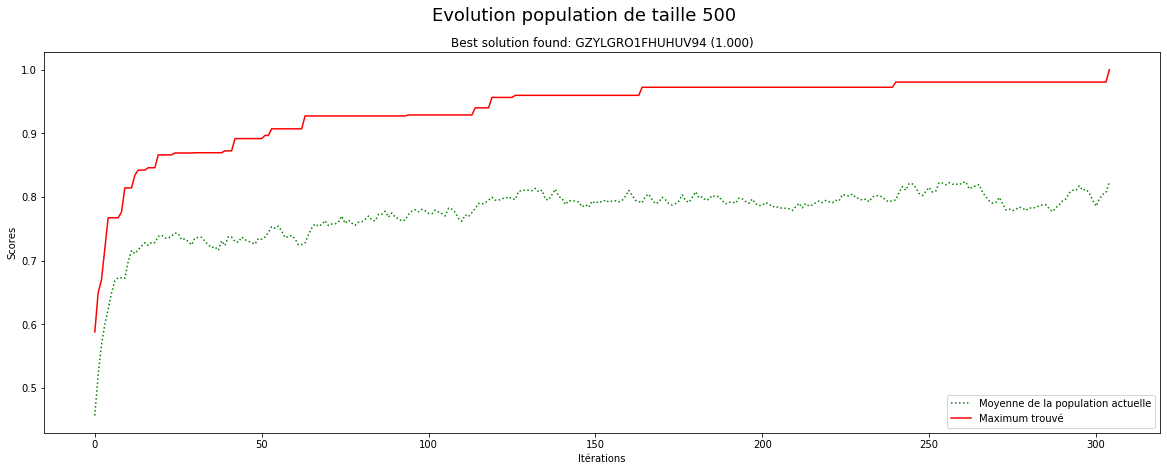

In [29]:
search(500, 500)

Search 1/10
Best solution found: GZYLGO1FHUHUV94 (0.979)


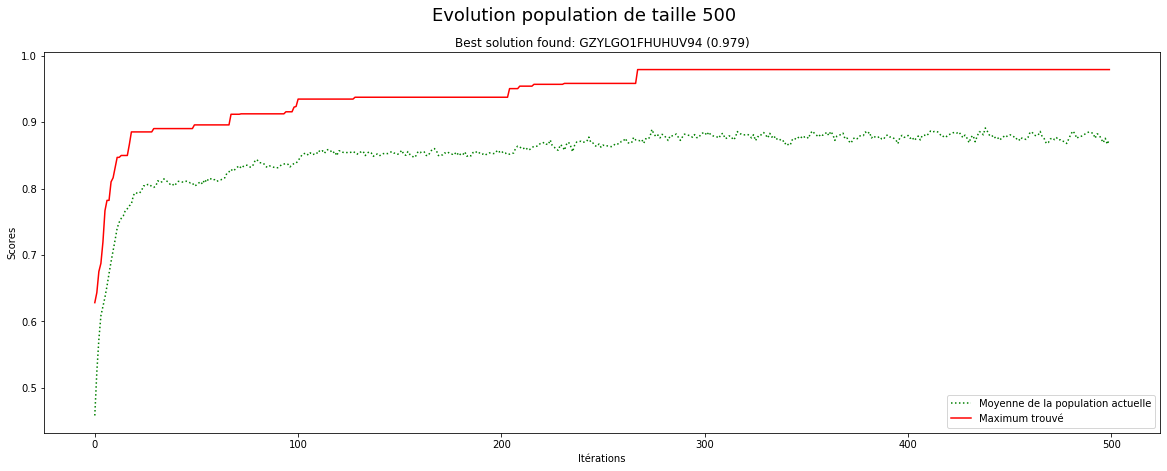

Search 2/10
Best found: GZYLGRO1FHUHUV94 at Epoch 321/500!
Best solution found: GZYLGRO1FHUHUV94 (1.000)


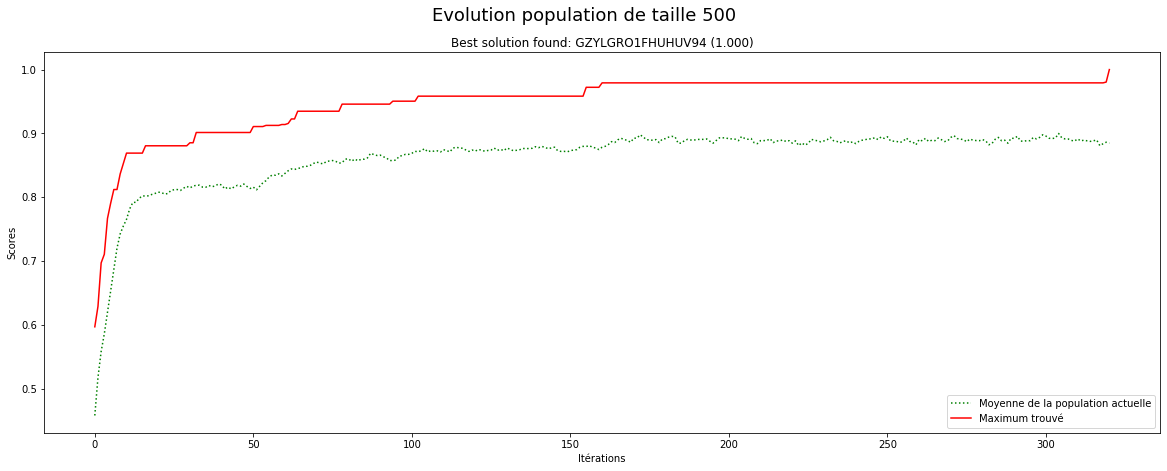

Search 3/10
Best found: GZYLGRO1FHUHUV94 at Epoch 416/500!
Best solution found: GZYLGRO1FHUHUV94 (1.000)


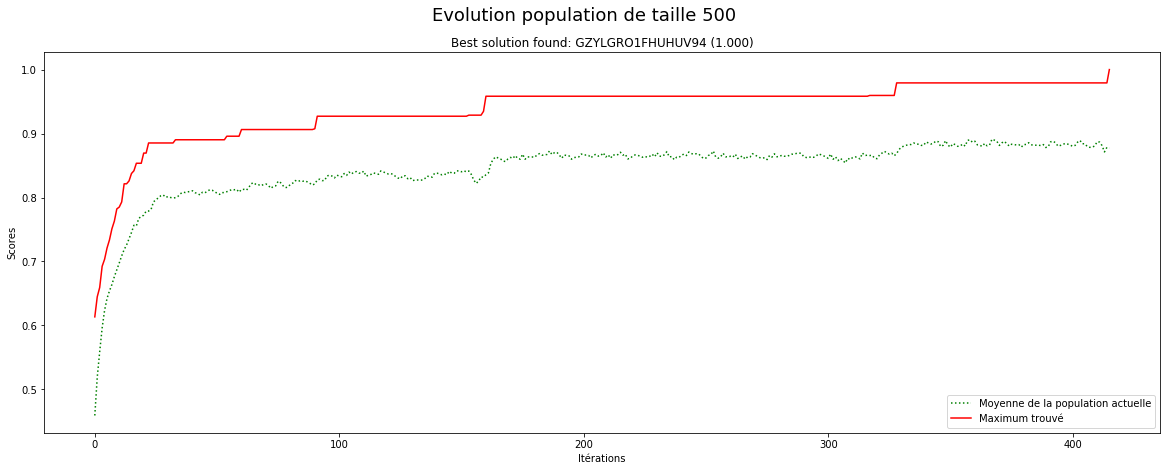

Search 4/10
Best solution found: GLGROFUHUH1V94 (0.923)


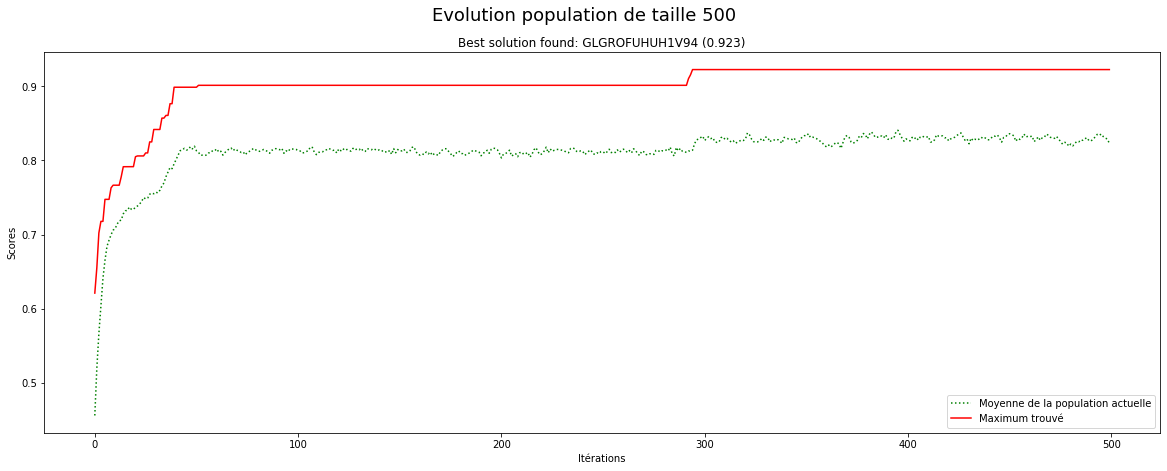

Search 5/10
Best solution found: ZGYLGRFHUHUV94 (0.935)


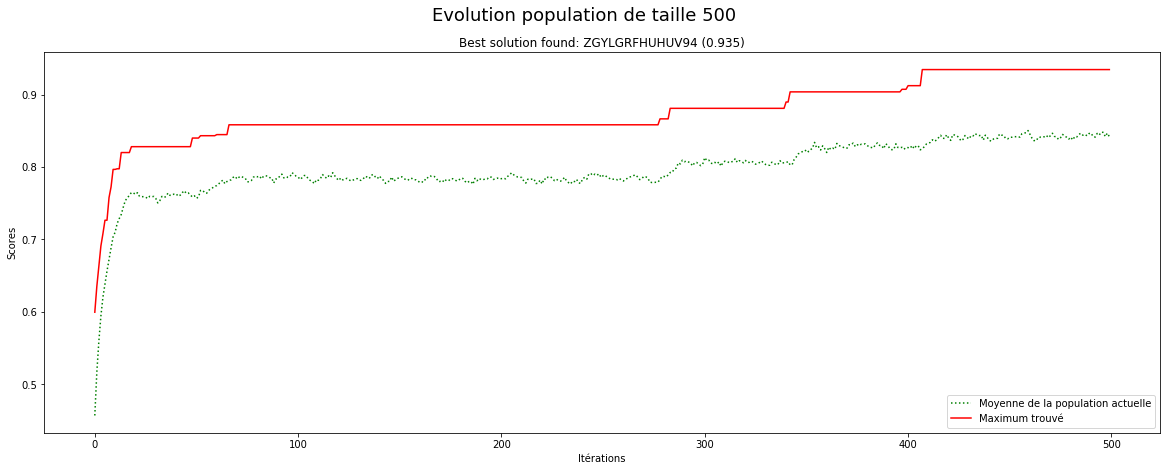

Search 6/10
Best solution found: OZYLGRGUFH1HUV94 (0.958)


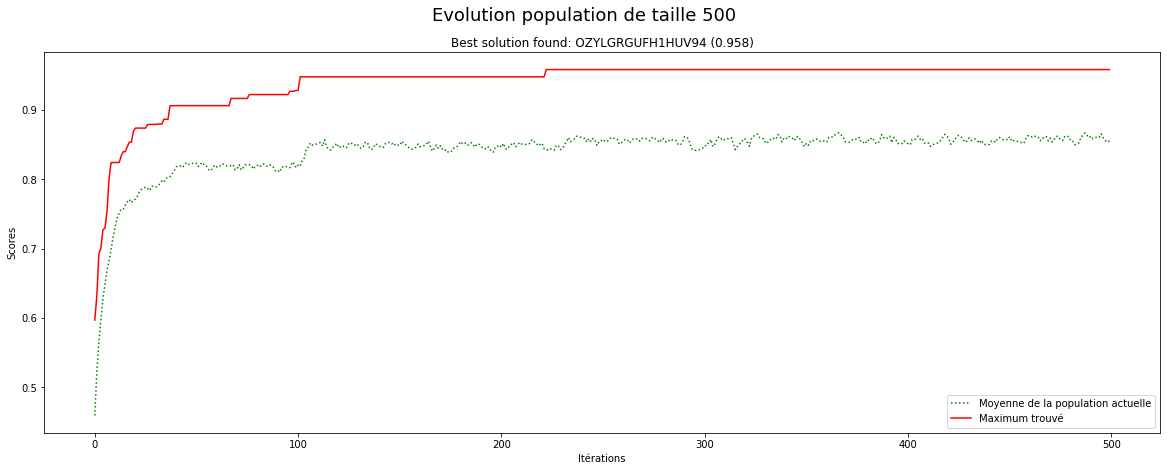

Search 7/10
Best solution found: IZYLO1HUUV9JTH49S (0.846)


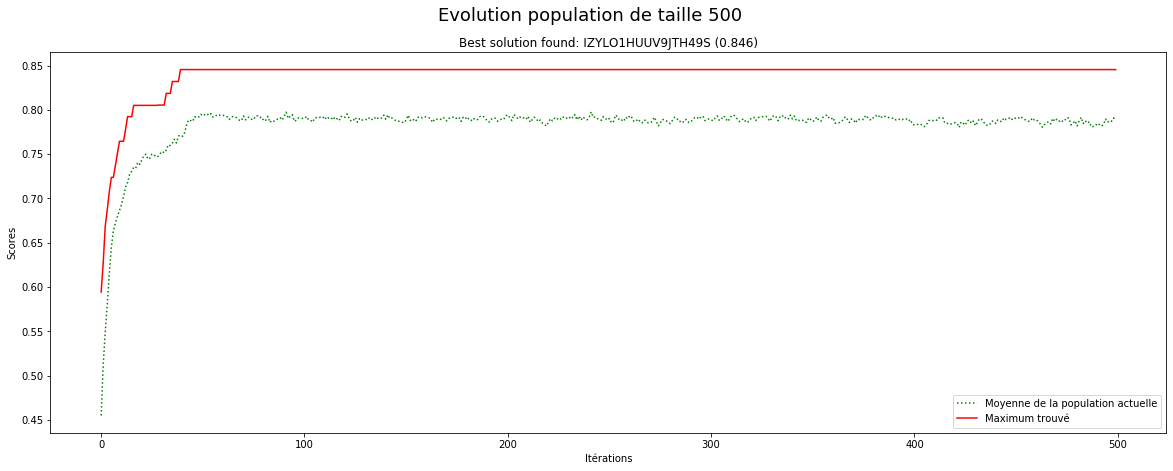

Search 8/10
Best solution found: GZYUROGF1HHUV94 (0.935)


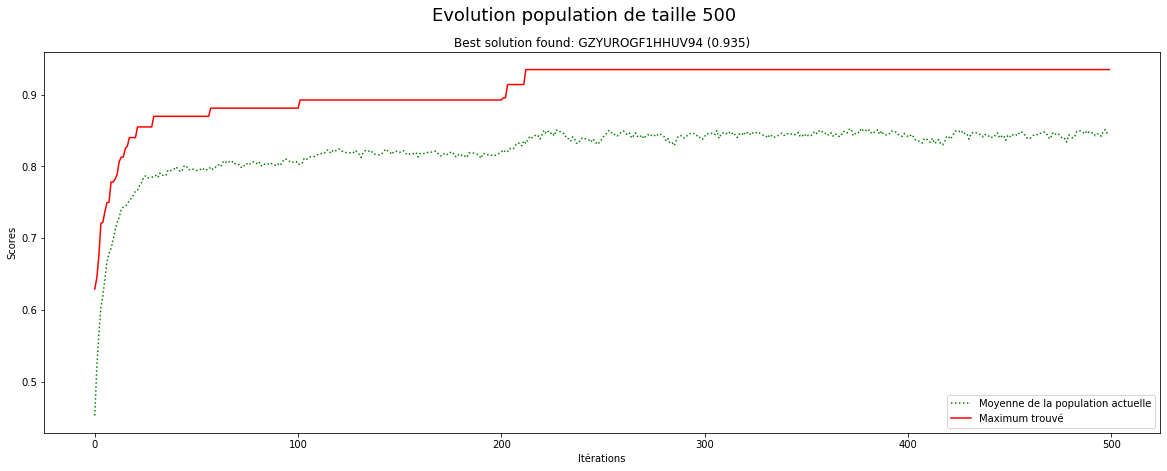

Search 9/10
Best found: GZYLGRO1FHUHUV94 at Epoch 127/500!
Best solution found: GZYLGRO1FHUHUV94 (1.000)


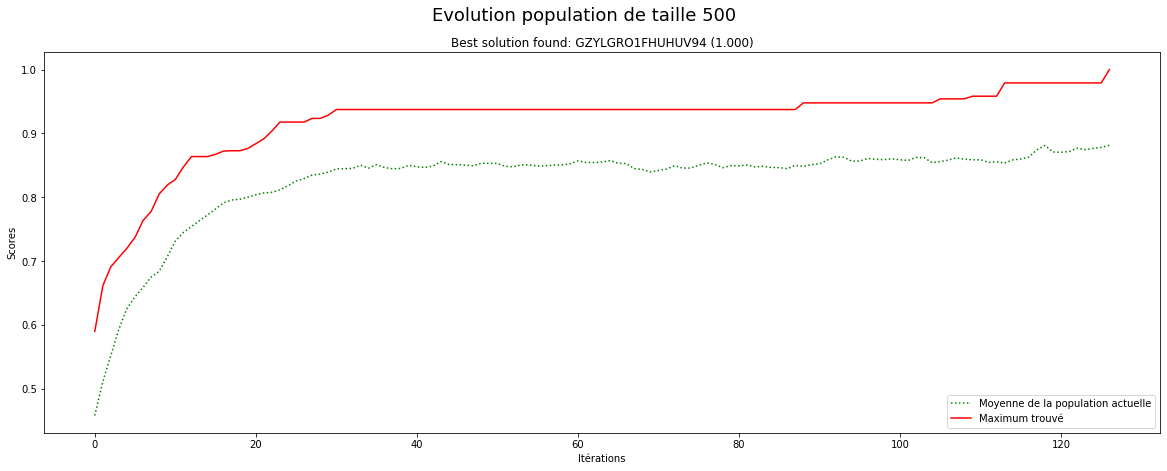

Search 10/10
Best solution found: GZYLGRO1FHUHUV4 (0.979)


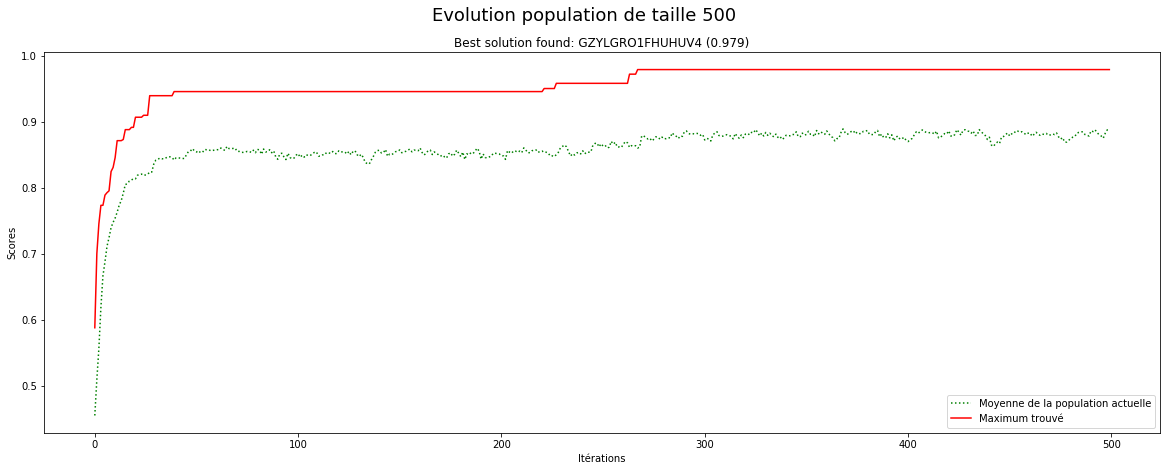

In [37]:
for i in range(10): #From 100 to 1000
    print(f"Search {i+1}/10")
    search(500, 500)